In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import datetime
%load_ext tensorboard
!rm -rf ./logs/ 

## Load data

In [4]:
df = pd.read_csv('../input/historical-hourly-weather-data/temperature.csv')
df.isnull().sum()

datetime               0
Vancouver            795
Portland               1
San Francisco        793
Seattle                3
Los Angeles            3
San Diego              1
Las Vegas              1
Phoenix                3
Albuquerque            1
Denver                 1
San Antonio            1
Dallas                 4
Houston                3
Kansas City            1
Minneapolis           13
Saint Louis            1
Chicago                3
Nashville              2
Indianapolis           7
Atlanta                6
Detroit                1
Jacksonville           1
Charlotte              3
Miami                805
Pittsburgh             3
Toronto                1
Philadelphia           3
New York             793
Montreal               3
Boston                 3
Beersheba            798
Tel Aviv District    793
Eilat                792
Haifa                798
Nahariyya            797
Jerusalem            793
dtype: int64

In [5]:
temperature = df.Portland[1:]
time = df.datetime[1:]
temperature

1        282.080000
2        282.083252
3        282.091866
4        282.100481
5        282.109095
            ...    
45248    282.000000
45249    282.890000
45250    283.390000
45251    283.020000
45252    282.280000
Name: Portland, Length: 45252, dtype: float64

In [6]:
X_train, X_test = train_test_split(temperature, test_size=0.2, shuffle=False)
X_train.values.shape

(36201,)

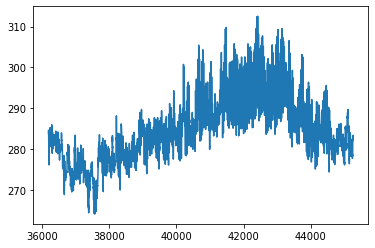

In [7]:
plt.plot(X_test)

### Example

In [8]:
dataset = tf.data.Dataset.range(10)
print(dataset)
dataset = dataset.window(5, shift=1, drop_remainder=True)
print(dataset)
dataset = dataset.flat_map(lambda window: window.batch(5))
print(dataset)
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
print(dataset)
for x, y in dataset:
    print(x.numpy(), y.numpy())

<RangeDataset shapes: (), types: tf.int64>
<WindowDataset shapes: DatasetSpec(TensorSpec(shape=(), dtype=tf.int64, name=None), TensorShape([])), types: DatasetSpec(TensorSpec(shape=(), dtype=tf.int64, name=None), TensorShape([]))>
<FlatMapDataset shapes: (None,), types: tf.int64>
<MapDataset shapes: ((None,), (None,)), types: (tf.int64, tf.int64)>
[0 1 2 3] [4]
[1 2 3 4] [5]
[2 3 4 5] [6]
[3 4 5 6] [7]
[4 5 6 7] [8]
[5 6 7 8] [9]


In [9]:
dataset = tf.data.Dataset.from_tensor_slices(X_train)
print(dataset)
dataset = dataset.window(5, shift=1, drop_remainder=True)
print(dataset)
dataset = dataset.flat_map(lambda window: window.batch(5))
print(dataset)
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
print(dataset)
for ii, (x, y) in enumerate(dataset):
    print(x.numpy(), y.numpy())
    if ii > 10: break

<TensorSliceDataset shapes: (), types: tf.float64>
<WindowDataset shapes: DatasetSpec(TensorSpec(shape=(), dtype=tf.float64, name=None), TensorShape([])), types: DatasetSpec(TensorSpec(shape=(), dtype=tf.float64, name=None), TensorShape([]))>
<FlatMapDataset shapes: (None,), types: tf.float64>
<MapDataset shapes: ((None,), (None,)), types: (tf.float64, tf.float64)>
[282.08       282.08325197 282.09186648 282.10048098] [282.10909548]
[282.08325197 282.09186648 282.10048098 282.10909548] [282.11770998]
[282.09186648 282.10048098 282.10909548 282.11770998] [282.12632448]
[282.10048098 282.10909548 282.11770998 282.12632448] [282.13493898]
[282.10909548 282.11770998 282.12632448 282.13493898] [282.14355348]
[282.11770998 282.12632448 282.13493898 282.14355348] [282.15216798]
[282.12632448 282.13493898 282.14355348 282.15216798] [282.16078248]
[282.13493898 282.14355348 282.15216798 282.16078248] [282.16939698]
[282.14355348 282.15216798 282.16078248 282.16939698] [282.17801149]
[282.152167

## Create dataset

In [10]:
def create_dataset(series, window_size, batch_size, shuffle_buffer, step=1):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    print(dataset)
    dataset = dataset.window(window_size + 1, shift=step, drop_remainder=True)
    print(dataset)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    print(dataset)
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
    print(dataset)
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

def create_datasetV2(series, window_size, batch_size, shuffle_buffer, step=1):
    return tf.keras.preprocessing.sequence.TimeseriesGenerator(
    series, series, window_size, sampling_rate=step, stride=1, start_index=0, end_index=None,
    shuffle=False, reverse=False, batch_size=batch_size)

## Create model

In [11]:
def create_model():
    return tf.keras.Sequential([
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
        tf.keras.layers.Conv1D(32, 5, padding='causal', activation='relu'),
        tf.keras.layers.LSTM(32, return_sequences=True),
        tf.keras.layers.LSTM(32, return_sequences=True),
        #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
        #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.Dense(1),
    ])

## Compile model

In [12]:
X = create_dataset(X_train, 32, 64, 1000)
X_test = create_dataset(X_test, 32, 64, 1000)
model = create_model()
model.compile(optimizer='Adam', loss='Huber', metrics=['mae'])
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

<TensorSliceDataset shapes: (), types: tf.float64>
<WindowDataset shapes: DatasetSpec(TensorSpec(shape=(), dtype=tf.float64, name=None), TensorShape([])), types: DatasetSpec(TensorSpec(shape=(), dtype=tf.float64, name=None), TensorShape([]))>
<FlatMapDataset shapes: (None,), types: tf.float64>
<MapDataset shapes: ((None,), (None,)), types: (tf.float64, tf.float64)>
<TensorSliceDataset shapes: (), types: tf.float64>
<WindowDataset shapes: DatasetSpec(TensorSpec(shape=(), dtype=tf.float64, name=None), TensorShape([])), types: DatasetSpec(TensorSpec(shape=(), dtype=tf.float64, name=None), TensorShape([]))>
<FlatMapDataset shapes: (None,), types: tf.float64>
<MapDataset shapes: ((None,), (None,)), types: (tf.float64, tf.float64)>


## Fit model

In [13]:
model.fit(X, epochs=10, validation_data=X_test, callbacks=[tensorboard_callback])

Epoch 1/10
566/566 [==============================] - 9s 16ms/step - loss: 267.0753 - mae: 267.5753 - val_loss: 256.2073 - val_mae: 256.7073
Epoch 2/10
566/566 [==============================] - 8s 15ms/step - loss: 246.9602 - mae: 247.4602 - val_loss: 237.2340 - val_mae: 237.7340
Epoch 3/10
566/566 [==============================] - 8s 15ms/step - loss: 228.1481 - mae: 228.6481 - val_loss: 218.5286 - val_mae: 219.0286
Epoch 4/10
566/566 [==============================] - 8s 14ms/step - loss: 209.4958 - mae: 209.9958 - val_loss: 199.9168 - val_mae: 200.4168
Epoch 5/10
566/566 [==============================] - 8s 14ms/step - loss: 190.9081 - mae: 191.4081 - val_loss: 181.3480 - val_mae: 181.8480
Epoch 6/10
566/566 [==============================] - 8s 15ms/step - loss: 172.3513 - mae: 172.8513 - val_loss: 162.8014 - val_mae: 163.3013
Epoch 7/10
566/566 [==============================] - 9s 16ms/step - loss: 153.8112 - mae: 154.3112 - val_loss: 144.2666 - val_mae: 144.7666
Epoch 8/10
56

In [14]:
%tensorboard --logdir logs/fit

## Create biderectional model

In [15]:
def create_model_bidirectional():
    return tf.keras.Sequential([
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
        tf.keras.layers.Conv1D(32, 5, padding='causal', activation='relu'),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.Dense(1),
    ])

In [16]:
model = create_model_bidirectional()
model.compile(optimizer='Adam', loss='Huber', metrics=['mae'])

In [17]:
model.fit(X, epochs=10, validation_data=X_test, callbacks=[tensorboard_callback])

Epoch 1/10
566/566 [==============================] - 12s 20ms/step - loss: 256.9541 - mae: 257.4541 - val_loss: 236.8012 - val_mae: 237.3012
Epoch 2/10
566/566 [==============================] - 10s 18ms/step - loss: 218.5014 - mae: 219.0014 - val_loss: 199.6939 - val_mae: 200.1939
Epoch 3/10
566/566 [==============================] - 11s 20ms/step - loss: 181.6204 - mae: 182.1204 - val_loss: 162.9634 - val_mae: 163.4634
Epoch 4/10
566/566 [==============================] - 10s 18ms/step - loss: 144.9643 - mae: 145.4644 - val_loss: 126.3637 - val_mae: 126.8637
Epoch 5/10
566/566 [==============================] - 11s 19ms/step - loss: 108.3980 - mae: 108.8980 - val_loss: 89.8238 - val_mae: 90.3238
Epoch 6/10
566/566 [==============================] - 10s 18ms/step - loss: 71.8748 - mae: 72.3748 - val_loss: 53.3143 - val_mae: 53.8143
Epoch 7/10
566/566 [==============================] - 10s 18ms/step - loss: 35.3742 - mae: 35.8742 - val_loss: 16.8654 - val_mae: 17.3638
Epoch 8/10
566/5

In [18]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6007 (pid 235), started 0:02:49 ago. (Use '!kill 235' to kill it.)

## Create bidirectional model without last sequences

In [19]:
def create_model_bidirectional_return_sequences_false():
    return tf.keras.Sequential([
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
        tf.keras.layers.Conv1D(32, 5, padding='causal', activation='relu'),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False)),
        tf.keras.layers.Dense(1),
    ])

In [20]:
model = create_model_bidirectional_return_sequences_false()
model.compile(optimizer='Adam', loss='Huber', metrics=['mae'])

In [ ]:
model.fit(X, epochs=10, validation_data=X_test, callbacks=[tensorboard_callback])

Epoch 1/10
566/566 [==============================] - 12s 21ms/step - loss: 255.5859 - mae: 256.0859 - val_loss: 235.1845 - val_mae: 235.6845
Epoch 2/10
566/566 [==============================] - 10s 17ms/step - loss: 216.7284 - mae: 217.2284 - val_loss: 197.7628 - val_mae: 198.2628
Epoch 3/10
566/566 [==============================] - 10s 17ms/step - loss: 179.5309 - mae: 180.0309 - val_loss: 160.7146 - val_mae: 161.2146
Epoch 4/10
566/566 [==============================] - 11s 19ms/step - loss: 142.5574 - mae: 143.0574 - val_loss: 123.7977 - val_mae: 124.2977
Epoch 5/10
566/566 [==============================] - 10s 18ms/step - loss: 105.6738 - mae: 106.1738 - val_loss: 86.9406 - val_mae: 87.4406
Epoch 6/10
566/566 [==============================] - 10s 18ms/step - loss: 68.8336 - mae: 69.3336 - val_loss: 50.1140 - val_mae: 50.6140
Epoch 7/10
566/566 [==============================] - 10s 18ms/step - loss: 32.0159 - mae: 32.5159 - val_loss: 13.3984 - val_mae: 13.8944
Epoch 8/10
566/5